In [5]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Looking at the X, y
X.shape, y.shape, X[:10], y[:10]

((3629,),
 (3629,),
 array([41, 18, 46, 18, 65,  8,  9, 41, 18, 46]),
 array([18, 46, 18, 65,  8,  9, 41, 18, 46, 18]))

In [6]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for layer in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
        
        # for layer in range(self.L):
        # layer = 0 # 1st layer or input layer
        for layer in range(0, 1):
            for X in X_train:
                X_one_hot = np.zeros(self.D)
                X_one_hot[X] = 1.
                X = X_one_hot.reshape(1, -1)
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                ys.append(y)
            
        # for layer in range(self.L): # from 0 to L-1
        for layer in range(1, self.L):
            Xs = ys.copy()
            ys = []
            for X in Xs:
                X = X.reshape(1, -1)
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                ys.append(y)

        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = dys.copy()
        for layer in reversed(range(self.L)):
            dys = dXs.copy()
            for t in reversed(range(len(dys))):
                dy = dys[t]
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dXs[t] = dX
                
        return dXs, grads

    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [8]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    #for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 200)
            print(sample)

    return nn

In [ ]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 150 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 217.4754
 the IusAst lons Iy. en thed Alon in the Ggols ey cantry Inst9  anth ed asob icelte hintre WeFtalt. the BakoNsg rnk4o nhees Aapoin toIneG the -abab alDe-ficinosak Ig Gnto5y Rheab oobs-f in the Gubhtere
Iter-2 loss: 237.0015
 firsd-laresex pard ex rite Glxms Narke Japet, 9nked yar, the 12hih the Glhexlexpet morten lakesofenthin Iortes cioxr ant fhext in al5PinkenrtDesgend ,est s paysek of the Mditpiimitorind s6 bo2 portes 
Iter-3 loss: 217.2801
 enkt o7somy in ma7. Japan is the Eth-tere Wantr anas edki. the G20)–. The G25760unrlase hoalt, is the eiviteobO0本-panked. pienteentry Nosn rD rnd .i2rl lcint in.. exfrst et inopend in cheuda to letan 
Iter-4 loss: 194.5321
 rast o.UJbm9enyty in funtrinaness rexpones the oxtod the G latin hinstarnskex. wto mitar mivensanked last exfexborl this and bixpopex lodent Japany Nobber inest en en Chinten in 194h, the furte antst 
Iter-5 loss: 196.9344
 antitfJatar is therest pered byt Pith the Gsex."stankeke nant in the Comlist fort

Iter-38 loss: 47.2820
 the world, and ranked The hich country in sake mataing gad cinteral mol waice Country Brand NiEangs sin the Warr pegistare fourth-largest maienoutiry  ester Imperor metrthe lorth% a military ppist inf
Iter-39 loss: 48.4699
 was pelore cane an is lien 1h the world1m1Plolitir noumhor anisla, Larko foplol Devixto nu, Japan is an soly Upuntron ea soxthe 12th cancifal 1987h centrin to deftopbe Ease country has the world's thi
Iter-40 loss: 47.3172
 of inclest of an Emnento and an conald country in Ease high str larggest in etre Gheasing noled Japanese pero. Japan was the first country in Asia to host bicrofomicito population. In meletains a fore
Iter-41 loss: 46.3327
 and the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Risth-lepan entire
Iter-42 loss: 43.9031
 and fourth-largest importer. Although Japan has officially renounced its right to

Iter-1 loss: 240.1561
 Nsdifiojee rocang Aowe the 22un 1t Aste b3ost oth Indin fir ceugencexto card Ir. Inu the fiwoP Glonu
Iter-2 loss: 218.8831
 weoptrorts re curthe in the seojtogexexpetntivurcesc in the wimh e5 e9n rean sorare larician thearot
Iter-3 loss: 239.0831
 hilice larexpinklat ow any rank iny co unlya rodin eanke cextral oUnduwey in od iny an the worikkes 
Iter-4 loss: 206.4026
 in is rookys the Gxbll8to exelonte Inedex ofangilet.ach the-G156 f itors thin ofy Dandind om an il 1
Iter-5 loss: 200.5251
 expeife peaten Japan tins tete. thins the Reaj Index ca. Iult in pons miloenced6sas coultng pangd wa
Iter-6 loss: 189.9345
 italy Iniac of RouFlaepoplrconlitan the morin an itorlaand Axpankit gith of NoItIunlare Co nano-Hbin
Iter-7 loss: 179.1589
 tamopetrond wopistity of losth nrexead Japan, -fefenter ofapeinom Japan is creand as bouncry in the 
Iter-8 loss: 183.2821
 Wirth end fortinlsest cutity it in sikins its, the Gpan miritany yate the Gl cextacy in the Glabo Si
Iter-9 l

Iter-67 loss: 34.2323
 War II in 1941, which came to declormemeate lorandinsir ituanejebopent-ranky.f ingades of Hiliveld C
Iter-68 loss: 33.1393
 as expecercion ome coraligic capeanid8ectopres seedepted al country in Asia. Japan is ranked first i
Iter-69 loss: 33.8219
 Dexpant g-le Infof 126 million is the world's thir-.–3wan historked Fixth lawthe nokiot41. moipuncin
Iter-70 loss: 32.9552
 the world, and ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness R
Iter-71 loss: 33.5479
 country in A"Wansma–t coned first in the Country Brand Index, ranked sixth in the Global Competitive
Iter-72 loss: 32.7903
 The ca destory the world's eighth largest military budget, used for self-defense and peacekeeping ro
Iter-73 loss: 33.3737
 or Nihon; formally. About this sound Nippon-koku or Nihon-koku, "State of Japan") is an island count
Iter-74 loss: 32.6313
 the nEmptrinured Stt regesolici"liadand upany Ifuinty in the Global Competitiveness Report 2015–2016
Iter-75 

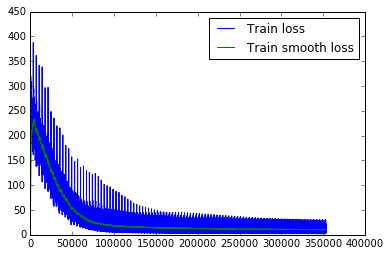

In [16]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 2 # depth
# n_iter = 100 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()